<a href="https://colab.research.google.com/github/samarth2015/CS203_Lab_01/blob/main/task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from transformers import AutoImageProcessor, ResNetConfig, ResNetForImageClassification
import torch
import os
import random

In [3]:
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn as nn

## Model on original dataset

In [4]:
# Dataset paths
data_dir = "/content/drive/MyDrive/dataset"

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard ResNet normalization
])

In [5]:
# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

cat_indices = [i for i in range(len(dataset)) if dataset.imgs[i][1] == 0]  # All cat indices
dog_indices = [i for i in range(len(dataset)) if dataset.imgs[i][1] == 1]  # All dog indices

train_indices = cat_indices[:56] + dog_indices[:56]
test_indices = cat_indices[56:] + dog_indices[56:]

random.shuffle(train_indices)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [6]:
# Map class indices for better clarity
class_names = dataset.classes
print("Classes:", class_names)

Classes: ['cats', 'dogs']


In [7]:
from transformers import ResNetConfig, ResNetForImageClassification

config = ResNetConfig.from_pretrained("microsoft/resnet-50")
config.num_labels = len(class_names)
model = ResNetForImageClassification(config)

### Showing the configuration and architecture diagram of ResNet 50

In [8]:
model.config

ResNetConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "ResNetForImageClassification"
  ],
  "depths": [
    3,
    4,
    6,
    3
  ],
  "downsample_in_bottleneck": false,
  "downsample_in_first_stage": false,
  "embedding_size": 64,
  "hidden_act": "relu",
  "hidden_sizes": [
    256,
    512,
    1024,
    2048
  ],
  "layer_type": "bottleneck",
  "model_type": "resnet",
  "num_channels": 3,
  "out_features": [
    "stage4"
  ],
  "out_indices": [
    4
  ],
  "stage_names": [
    "stem",
    "stage1",
    "stage2",
    "stage3",
    "stage4"
  ],
  "torch_dtype": "float32",
  "transformers_version": "4.48.2"
}

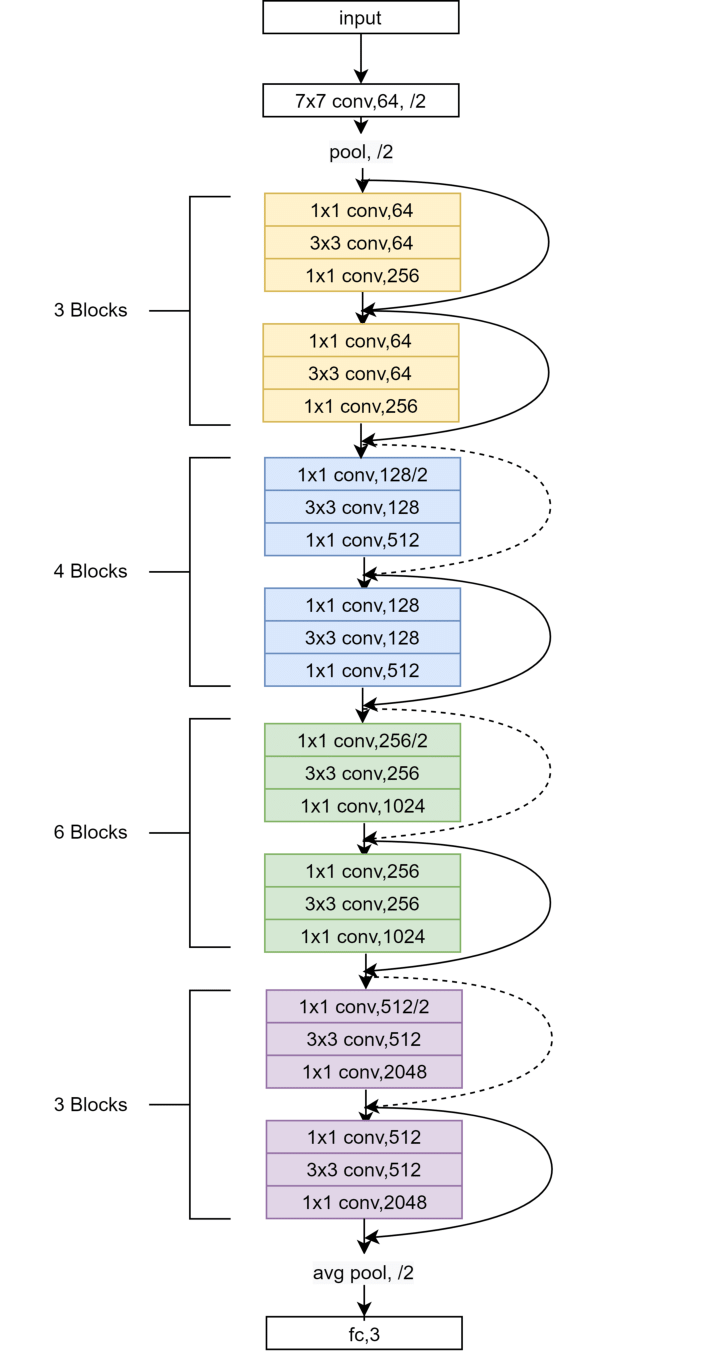

## Training and Testing the model

In [9]:
# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [11]:
# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs).logits  # .logits for transformers models
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_dataloader)}")

print("Training complete.")

Epoch 1/10, Loss: 0.8415356406143734
Epoch 2/10, Loss: 0.7349984390395028
Epoch 3/10, Loss: 0.5813824960163662
Epoch 4/10, Loss: 0.6449225800377982
Epoch 5/10, Loss: 0.45021766424179077
Epoch 6/10, Loss: 0.37571356126240324
Epoch 7/10, Loss: 0.3474641080413546
Epoch 8/10, Loss: 0.3989316714661462
Epoch 9/10, Loss: 0.22576103146587098
Epoch 10/10, Loss: 0.1690130742000682
Training complete.


In [12]:
# Evaluate the model
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).logits
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

In [13]:
# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

Accuracy: 67.86%
Precision: 73.81%
Recall: 67.86%
F1 Score: 65.71%


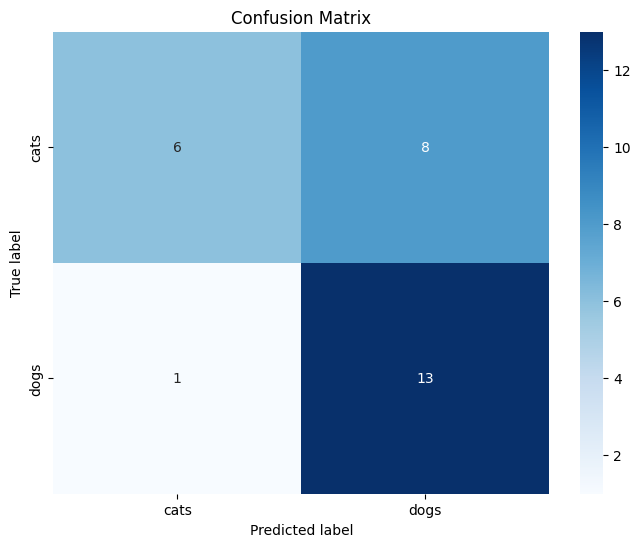

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


## Model on augmented dataset

In [15]:
# Dataset paths
data_dir = "/content/drive/MyDrive/dataset_augmented"

dataset_augmented = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader_augmented = DataLoader(dataset_augmented, batch_size=16, shuffle=True)

In [17]:
ones = 0
zeros = 0
for image, label in dataloader_augmented:
    ones += (label == 1).sum().item()
    zeros += (label == 0).sum().item()

print(f"Number of ones: {ones}")
print(f"Number of zeros: {zeros}")

Number of ones: 112
Number of zeros: 112


In [47]:
config = ResNetConfig.from_pretrained("microsoft/resnet-50")
config.num_labels = len(class_names)  # Set number of output classes
model = ResNetForImageClassification(config)

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [48]:
# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in dataloader_augmented:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs).logits  # .logits for transformers models
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(dataloader_augmented)}")


print("Training complete.")

Epoch 1/20, Loss: 0.7688989596707481
Epoch 2/20, Loss: 0.7533876640456063
Epoch 3/20, Loss: 0.7112140847103936
Epoch 4/20, Loss: 0.6382570117712021
Epoch 5/20, Loss: 0.6638213481221881
Epoch 6/20, Loss: 0.6037371499197823
Epoch 7/20, Loss: 0.6886968953268868
Epoch 8/20, Loss: 0.5819034618990762
Epoch 9/20, Loss: 0.48599373762096676
Epoch 10/20, Loss: 0.6159743943384716
Epoch 11/20, Loss: 0.5201755166053772
Epoch 12/20, Loss: 0.5047919303178787
Epoch 13/20, Loss: 0.357103027935539
Epoch 14/20, Loss: 0.31203204712697435
Epoch 15/20, Loss: 0.373918999518667
Epoch 16/20, Loss: 0.26082708686590195
Epoch 17/20, Loss: 0.25720122137240004
Epoch 18/20, Loss: 0.2363898376269
Epoch 19/20, Loss: 0.24457877741328307
Epoch 20/20, Loss: 0.2145535003926073
Training complete.


In [49]:
# Evaluate the model
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).logits
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

In [50]:
# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

Accuracy: 53.57%
Precision: 54.09%
Recall: 53.57%
F1 Score: 52.04%


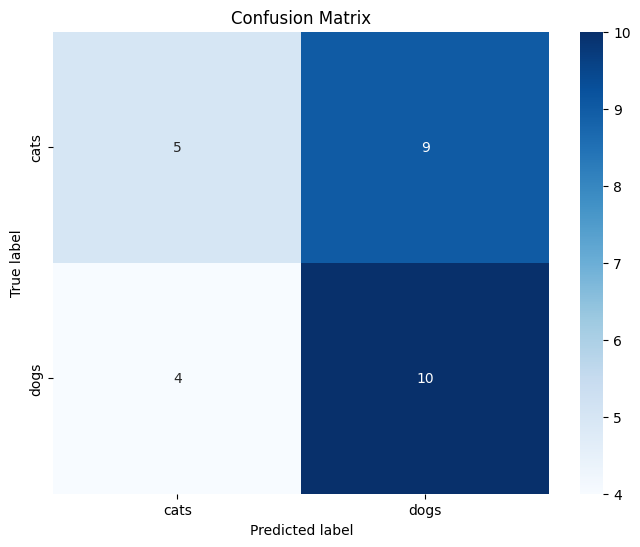

In [51]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


### Checking the model on train dataset

In [53]:
#checking the model on train dataset
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).logits
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

In [54]:
# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

Accuracy: 86.61%
Precision: 88.69%
Recall: 86.61%
F1 Score: 86.42%


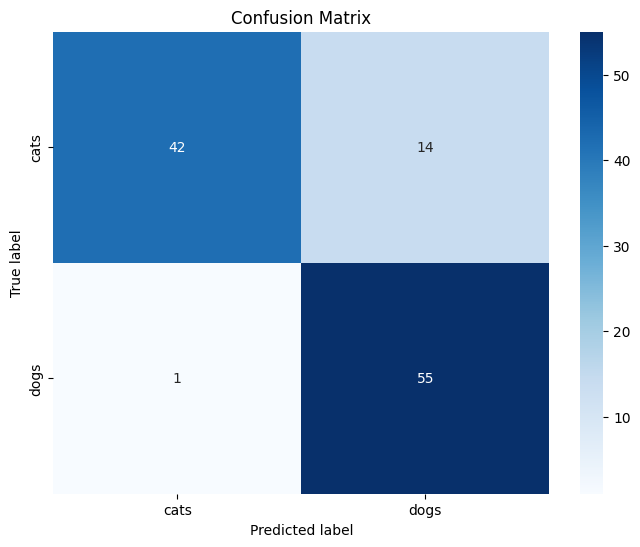

In [55]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()